In [3]:
from pathlib import Path

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc =  BrainObservatoryCache(
    manifest_file=str(Path('/media/maria/DATA/AllenData') / 'brain_observatory_manifest.json'))

# Download a list of all targeted areas
targeted_structures = boc.get_all_targeted_structures()
print("all targeted structures: " + str(targeted_structures))

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']


In [4]:
cux2_ecs = boc.get_experiment_containers(cre_lines=['Cux2-CreERT2'])
print("Cux2 experiments: %d\n" % len(cux2_ecs))

print("Example experiment container record:")
pprint.pprint(cux2_ecs[0])

Cux2 experiments: 76

Example experiment container record:
{'cre_line': 'Cux2-CreERT2',
 'donor_name': '222426',
 'failed': False,
 'id': 511510736,
 'imaging_depth': 175,
 'reporter_line': 'Ai93(TITL-GCaMP6f)',
 'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222426',
 'tags': [],
 'targeted_structure': 'VISp'}


In [9]:
ids=[ ec['id'] for ec in cux2_ecs ]
ids
for i in ids:
    try:
        events = boc.get_ophys_experiment_events(i)
    except:
        print("No events for experiment %d" % i)
        continue
    

[]
No events for experiment 511510736
[]
No events for experiment 511854338
[]
No events for experiment 511510855
[]
No events for experiment 658854535
[]
No events for experiment 511510645
[]
No events for experiment 716655272
[]
No events for experiment 511510715
[]
No events for experiment 710502979
[]
No events for experiment 511509529
[]
No events for experiment 511510753
[]
No events for experiment 511507650
[]
No events for experiment 702934962
[]
No events for experiment 511510994
[]
No events for experiment 511510867
[]
No events for experiment 645413757
[]
No events for experiment 511510998
[]
No events for experiment 659767480
[]
No events for experiment 511510650
[]
No events for experiment 699155263
[]
No events for experiment 569645688
[]
No events for experiment 660510591
[]
No events for experiment 511510870
[]
No events for experiment 712178509
[]
No events for experiment 566759225
[]
No events for experiment 511510797
[]
No events for experiment 511510836
[]
No events

In [3]:
# Find all of the experiments for an experiment container
cux2_ec_id = cux2_ecs[0]['id']
exps = boc.get_ophys_experiments(experiment_container_ids=[cux2_ec_id])
print("Experiments for experiment_container_id %d: %d\n" % (cux2_ec_id, len(exps)))
pprint.pprint(exps)

Experiments for experiment_container_id 511510736: 3

[{'acquisition_age_days': 103,
  'cre_line': 'Cux2-CreERT2',
  'donor_name': '222426',
  'experiment_container_id': 511510736,
  'fail_eye_tracking': True,
  'id': 501559087,
  'imaging_depth': 175,
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'session_type': 'three_session_B',
  'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222426',
  'targeted_structure': 'VISp'},
 {'acquisition_age_days': 104,
  'cre_line': 'Cux2-CreERT2',
  'donor_name': '222426',
  'experiment_container_id': 511510736,
  'fail_eye_tracking': True,
  'id': 501704220,
  'imaging_depth': 175,
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'session_type': 'three_session_A',
  'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222426',
  'targeted_structure': 'VISp'},
 {'acquisition_age_days': 102,
  'cre_line': 'Cux2-CreERT2',
  'donor_name': '222426',
  'experiment_container_id': 511510736,
  'fail_eye_tracking': True,
  'id': 501474098,
  'imaging_depth': 175,
  'reporter

In [4]:
import pandas as pd
import allensdk.brain_observatory.stimulus_info as stim_info
# Download experiment containers for VISp experiments
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISp'])
print("all VISp experiment containers: %d" % len(visp_ecs))
# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

# find direction selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]
print("VISp cells: %d" % len(visp_cells))

# significant response to drifting gratings stimulus
sig_cells = visp_cells[visp_cells['p_dg'] < 0.05]
print("cells with sig. response to drifting gratings: %d" % len(sig_cells))

# direction selective cells
dsi_cells = sig_cells[(sig_cells['g_dsi_dg'] > 0.9)]
print("direction-selective cells: %d" % len(dsi_cells))

# pick a direction-selective cell and find its NWB file
dsi_cell = dsi_cells.iloc[0]

# figure out which ophys experiment has the drifting gratings stimulus for that cell
cell_exp = boc.get_ophys_experiments(cell_specimen_ids=[dsi_cell['cell_specimen_id']],
                                     stimuli=[stim_info.DRIFTING_GRATINGS])[0]

data_set = boc.get_ophys_experiment_data(cell_exp['id'])

print("Metadata from NWB file:")
pprint.pprint(data_set.get_metadata())

print("stimuli available in this file:")
print(data_set.list_stimuli())

all VISp experiment containers: 216
total cells: 63251
VISp cells: 22641
cells with sig. response to drifting gratings: 13401
direction-selective cells: 1159
Metadata from NWB file:
{'age_days': 93,
 'cre_line': 'Scnn1a-Tg3-Cre/wt',
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.2',
 'excitation_lambda': '910 nanometers',
 'experiment_container_id': 511498742,
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)',
 'imaging_depth_um': 350,
 'indicator': 'GCaMP6f',
 'ophys_experiment_id': 511534603,
 'pipeline_version': '3.0',
 'session_start_time': datetime.datetime(2016, 4, 1, 9, 12, 3),
 'session_type': 'three_session_A',
 'sex': 'female',
 'specimen_name': 'Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-231953',
 'targeted_structure': 'VISp'}
stimuli available in this file:
['drifting_gratings', 'natural_movie_one', 'natural_movie_three', 'spontaneous']


In [5]:
dsi_cell_id = dsi_cell['cell_specimen_id']
time, raw_traces = data_set.get_fluorescence_traces(cell_specimen_ids=[dsi_cell_id])
_, demixed_traces = data_set.get_demixed_traces(cell_specimen_ids=[dsi_cell_id])
_, neuropil_traces = data_set.get_neuropil_traces(cell_specimen_ids=[dsi_cell_id])
_, corrected_traces = data_set.get_corrected_fluorescence_traces(cell_specimen_ids=[dsi_cell_id])
_, dff_traces = data_set.get_dff_traces(cell_specimen_ids=[dsi_cell_id])

In [6]:
import matplotlib.pyplot as plt
print(dff_traces.shape)
#bplt.plot(dff_traces)

(1, 115477)


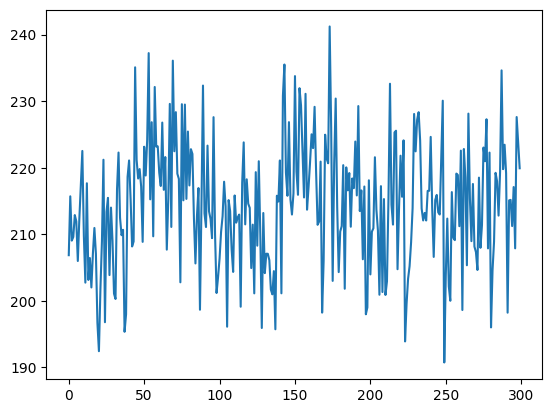

In [16]:
plt.plot(demixed_traces[0,:300])

(array([6.0000e+00, 3.5000e+01, 1.7300e+02, 5.5200e+02, 1.5660e+03,
        3.5420e+03, 6.8160e+03, 1.0814e+04, 1.4916e+04, 1.7020e+04,
        1.8141e+04, 1.4576e+04, 1.0458e+04, 6.9920e+03, 4.1270e+03,
        2.1740e+03, 1.0460e+03, 5.2100e+02, 2.7200e+02, 2.0600e+02,
        1.0300e+02, 8.2000e+01, 9.1000e+01, 7.5000e+01, 6.8000e+01,
        5.8000e+01, 7.5000e+01, 5.0000e+01, 4.5000e+01, 4.6000e+01,
        5.5000e+01, 3.9000e+01, 5.7000e+01, 4.2000e+01, 2.8000e+01,
        3.8000e+01, 2.1000e+01, 2.8000e+01, 1.5000e+01, 3.1000e+01,
        2.0000e+01, 2.6000e+01, 2.2000e+01, 2.0000e+01, 2.1000e+01,
        2.3000e+01, 1.6000e+01, 2.4000e+01, 1.0000e+01, 1.3000e+01,
        1.9000e+01, 1.3000e+01, 1.2000e+01, 1.9000e+01, 1.0000e+01,
        1.6000e+01, 7.0000e+00, 7.0000e+00, 8.0000e+00, 9.0000e+00,
        1.0000e+01, 1.2000e+01, 8.0000e+00, 8.0000e+00, 5.0000e+00,
        8.0000e+00, 6.0000e+00, 1.3000e+01, 7.0000e+00, 7.0000e+00,
        7.0000e+00, 3.0000e+00, 9.0000e+00, 3.00

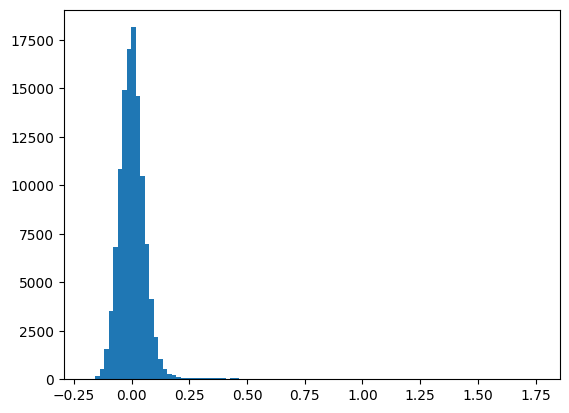

In [18]:
plt.hist(dff_traces.flatten(),bins=100)

In [11]:

from pathlib import Path

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc =  BrainObservatoryCache(
    manifest_file=str(Path('/media/maria/DATA/AllenData') / 'brain_observatory_manifest.json'))

# Download a list of all targeted areas
targeted_structures = boc.get_all_targeted_structures()
print("all targeted structures: " + str(targeted_structures))
#cell_exp = boc.get_ophys_experiments(646959386)
events = boc.get_ophys_experiment_events(501559087)


all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']


2024-06-13 12:13:50,013 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721211


[{'attachable_id': 501559087, 'attachable_type': 'OphysExperiment', 'download_link': '/api/v2/well_known_file_download/739721211', 'id': 739721211, 'path': '/external/neuralcoding/prod6/specimen_495727015/ophys_experiment_501559087/501559087_events.npz', 'well_known_file_type_id': 739716145}]


In [13]:
events.shape

(174, 113888)

In [19]:
events.shape

(174, 113888)

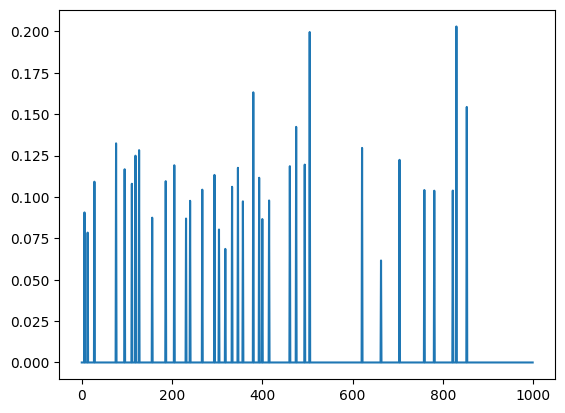

In [25]:
import matplotlib.pyplot as plt
plt.plot(events[2,:1000].flatten())


(array([1.11136e+05, 5.30000e+01, 6.60000e+01, 2.17000e+02, 2.04000e+02,
        1.62000e+02, 1.54000e+02, 1.36000e+02, 1.67000e+02, 1.10000e+02,
        1.25000e+02, 1.05000e+02, 9.90000e+01, 9.30000e+01, 8.70000e+01,
        8.30000e+01, 6.90000e+01, 8.20000e+01, 6.20000e+01, 4.10000e+01,
        6.30000e+01, 5.20000e+01, 5.00000e+01, 3.40000e+01, 3.80000e+01,
        3.40000e+01, 3.20000e+01, 2.60000e+01, 2.00000e+01, 2.50000e+01,
        3.00000e+01, 2.20000e+01, 2.10000e+01, 2.40000e+01, 2.90000e+01,
        1.80000e+01, 1.70000e+01, 1.60000e+01, 1.00000e+01, 1.10000e+01,
        1.40000e+01, 1.10000e+01, 4.00000e+00, 5.00000e+00, 4.00000e+00,
        4.00000e+00, 5.00000e+00, 2.00000e+00, 2.00000e+00, 1.00000e+00,
        2.00000e+00, 0.00000e+00, 1.00000e+00, 4.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

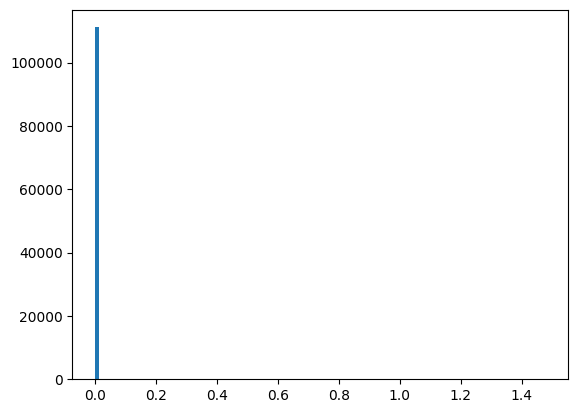

In [24]:
plt.hist(events[1,:].flatten(),bins=100)

In [3]:
!pip install --upgrade allensdk